In [46]:
import os
import matplotlib.pyplot as plt
import gc
import joblib
import time
import numpy as np
import pandas as pd
import nibabel as nib
import statsmodels.api as sm                                                                                        
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
from joblib import Parallel, delayed

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from utils import train_data_normalization, Timer, net_size_info, conv2_labels

In [2]:
# path settings
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
# input path
resp_path = pjoin(work_dir, 'prep/brain_response')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
image_activations_path = pjoin(work_dir, 'prep/image_activations')
concate_feature_path = pjoin(work_dir, 'prep/roi-concate')
retino_path = pjoin(work_dir, 'build/retinoparams')
guass_path = pjoin(work_dir, 'build/gaussianparams')
avgrf_path = pjoin(work_dir, 'prep/image_mask')
# save out path
performance_path = pjoin(work_dir, 'build/roi-cocatemodel/')

## Tuning 分析

- 1. 通过标准化刺激的实验 标定conv2每个channel的刺激选择性

In [9]:
# channel sorting 
# 肉眼设置 label 分类学
torch_conv2_label = {
    'gabor':[0, 4, 8, 10, 12, 19, 31, 32, 37, 41, 42, 43, 46, 50, 53, 60, 61],
    'color':[1, 6, 9, 14, 18, 21, 23, 25, 26, 29, 33, 34, 35, 38, 45, 49, 52, 57, 58, 63],
    'texture':[2, 3, 5, 7, 11, 13, 15, 16, 17, 20, 22, 24, 27, 28, 30, 36, 39, 40, 44, 47, 48, 51, 54, 55, 56, 59, 62]
}
# 按照 conv2_label sorting 绘图时的顺序
label_dict = torch_conv2_label
# 装载 indices 和颜色
setcolors = plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
print(draw_ticks, draw_tickslabels)
print(draw_sorting)
# 分 家族类型 
gabor_family = ['gabor']
color_family = ['color']
texture_family = ['texture']
gabor_channel, color_channel, texture_channel = [], [], []
label_dict = torch_conv2_label
for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in texture_family:
        texture_channel.extend(indices)
color_channel.pop(color_channel.index(63)) # 扔掉没用的
print(len(gabor_channel), len(color_channel), len(texture_channel))

[0, 17, 37, 64] ['gabor', 'color', 'texture']
[0, 4, 8, 10, 12, 19, 31, 32, 37, 41, 42, 43, 46, 50, 53, 60, 61, 1, 6, 9, 14, 18, 21, 23, 25, 26, 29, 33, 34, 35, 38, 45, 49, 52, 57, 58, 63, 2, 3, 5, 7, 11, 13, 15, 16, 17, 20, 22, 24, 27, 28, 30, 36, 39, 40, 44, 47, 48, 51, 54, 55, 56, 59, 62]
17 19 27


#### 分析一、确定每个神经元对不同类型特征的选择性

In [16]:
# 准备好激活值
activ_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodanalysis/simplified_stimuli/activation'
stim_type = ['color', 'gabor', 'shape']
net_layer = 'Googlenet_conv2'

activ_files = sorted([ _ for _ in os.listdir(activ_dir) if f'{net_layer}.npy' in _])
activs = list(map(lambda x: np.load(x, mmap_mode='r'), [pjoin(activ_dir, _) for _ in activ_files]))
activs[0].shape, activs[1].shape, activs[2].shape 

((396, 64, 56, 56), (270, 64, 56, 56), (1110, 64, 56, 56))

In [17]:
# 准备好实验条件
...

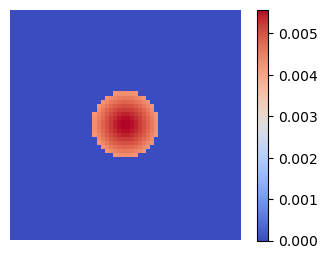

In [30]:
# 准备好感受野
# Define the 2D Gaussian function
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) #

    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)

    return cur_receptive_field

A, x, y, sigma_x, sigma_y, C = 1, 0, 0, 2, 2, 0

i = np.linspace(-8., 8., 56)
j = np.linspace(8., -8., 56)
i, j = np.meshgrid(i, j)
rfmask = adjust_RF(gaussian_2d((i, j), A, x, y, sigma_x, sigma_y, C))
plt.style.use('default')
plt.figure(figsize=(4,3))
plt.imshow(rfmask, cmap='coolwarm')
plt.colorbar()
plt.axis('off')
plt.show()

In [98]:
# 提出感受野范围内的激活值
sampled_activs = {}
print('提取感受野采样的激活值')
for i, key in enumerate(stim_type):
    sampled_activs[key] = np.sum( activs[i] * rfmask, axis=(2,3))
reshaped_matrix = sampled_activs['shape'].reshape((-1, 3, 64))
# 沿着第二个轴求平均值
sampled_activs['shape'] = reshaped_matrix.mean(axis=1)
for i, key in enumerate(stim_type):
    print(key, sampled_activs[key].shape)

提取感受野采样的激活值
color (396, 64)
gabor (270, 64)
shape (370, 64)


In [90]:
# 计算神经元的 d prime
dprim_color = []
for unit in range(64):
    mean = np.mean(sampled_activs['color'][:, unit])
    std = np.std(sampled_activs['color'][:, unit])

    mean_other = np.mean(np.r_[sampled_activs['shape'][:, unit], sampled_activs['gabor'][:, unit]])
    std_other = np.std(np.r_[sampled_activs['shape'][:, unit], sampled_activs['gabor'][:, unit]])

    dprim_color.append((mean - mean_other) / np.sqrt(0.5*(std**2 + std_other**2)))

dprim_shape = []
for unit in range(64):
    mean = np.mean(sampled_activs['shape'][:, unit])
    std = np.std(sampled_activs['shape'][:, unit])

    mean_other = np.mean(np.r_[sampled_activs['color'][:, unit], sampled_activs['gabor'][:, unit]])
    std_other = np.std(np.r_[sampled_activs['color'][:, unit], sampled_activs['gabor'][:, unit]])

    dprim_shape.append((mean - mean_other) / np.sqrt(0.5*(std**2 + std_other**2)))

dprim_gabor = []
for unit in range(64):
    mean = np.mean(sampled_activs['gabor'][:, unit])
    std = np.std(sampled_activs['gabor'][:, unit])

    mean_other = np.mean(np.r_[sampled_activs['shape'][:, unit], sampled_activs['color'][:, unit]])
    std_other = np.std(np.r_[sampled_activs['shape'][:, unit], sampled_activs['color'][:, unit]])

    dprim_gabor.append((mean - mean_other) / np.sqrt(0.5*(std**2 + std_other**2)))

In [91]:
# 计算神经元的 selectivity
color_selectivity = []
for unit in range(64):
    mean = np.mean(sampled_activs['color'][:, unit])
    mean_other = np.mean(np.r_[sampled_activs['shape'][:, unit], sampled_activs['gabor'][:, unit]])

    color_selectivity.append((mean - mean_other) / (mean + mean_other) )

shape_selectivity = []
for unit in range(64):
    mean = np.mean(sampled_activs['shape'][:, unit])
    mean_other = np.mean(np.r_[sampled_activs['color'][:, unit], sampled_activs['gabor'][:, unit]])

    shape_selectivity.append((mean - mean_other) / (mean + mean_other) )

gabor_selectivity = []
for unit in range(64):
    mean = np.mean(sampled_activs['gabor'][:, unit])
    mean_other = np.mean(np.r_[sampled_activs['shape'][:, unit], sampled_activs['color'][:, unit]])

    gabor_selectivity.append((mean - mean_other) / (mean + mean_other))

In [95]:
unitdata = {
    "unit" : np.arange(64),
    "color-d'": dprim_color,
    "shape-d'": dprim_shape,
    "gabor-d'": dprim_gabor,
    'color-sls': color_selectivity,
    'shape-sls': shape_selectivity,
    'gabor-sls': gabor_selectivity
}
df = pd.DataFrame(unitdata)
df.to_csv(pjoin(work_dir, 'anal/unit-selectivity/unit-info.csv'), index=False)
print(np.argmax(dprim_color), np.max(dprim_color), np.argmax(color_selectivity), np.max(color_selectivity))
print(np.argmax(dprim_shape), np.max(dprim_shape), np.argmax(shape_selectivity), np.max(shape_selectivity))
print(np.argmax(dprim_gabor), np.max(dprim_gabor), np.argmax(gabor_selectivity), np.max(gabor_selectivity))

9 1.627077067255245 23 0.7598014660184362
29 2.226150028269276 27 0.5584065496936518
11 1.6333886380495544 11 0.9797009212153043


In [96]:
# 按照 selectivity 给每个 channel 分类
stim_type = ['color', 'gabor', 'shape']
classify = np.argmax(np.c_[df['color-sls'], df['gabor-sls'], df['shape-sls']], axis=1)
selectivity_label = {'color':[], 'gabor':[], 'shape':[]}
for unit, keyid in enumerate(classify):
    selectivity_label[stim_type[keyid]].append(unit)
label_dict = selectivity_label
# 装载 indices 和颜色
setcolors = plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
print(draw_ticks, draw_tickslabels)
print(draw_sorting)
# 分 家族类型 
gabor_family = ['gabor']
color_family = ['color']
texture_family = ['shape']
gabor_channel, color_channel, texture_channel = [], [], []

for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in texture_family:
        texture_channel.extend(indices)
try:
    gabor_channel.pop(gabor_channel.index(63)) # 扔掉没用的
    print('63 in gabor')
except ValueError:
    try:
        color_channel.pop(color_channel.index(63)) # 扔掉没用的
        print('63 in color')
    except ValueError:
        texture_channel.pop(texture_channel.index(63)) # 扔掉没用的
        print('63 in texture')

print(len(gabor_channel), len(color_channel), len(texture_channel))

[0, 11, 49, 64] ['color', 'gabor', 'shape']
[1, 6, 7, 9, 18, 23, 25, 26, 45, 52, 58, 0, 3, 4, 5, 8, 11, 12, 13, 14, 15, 16, 19, 20, 22, 24, 28, 30, 31, 32, 36, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 53, 54, 56, 57, 59, 60, 61, 62, 2, 10, 17, 21, 27, 29, 33, 34, 35, 37, 38, 48, 49, 55, 63]
63 in texture
38 11 14


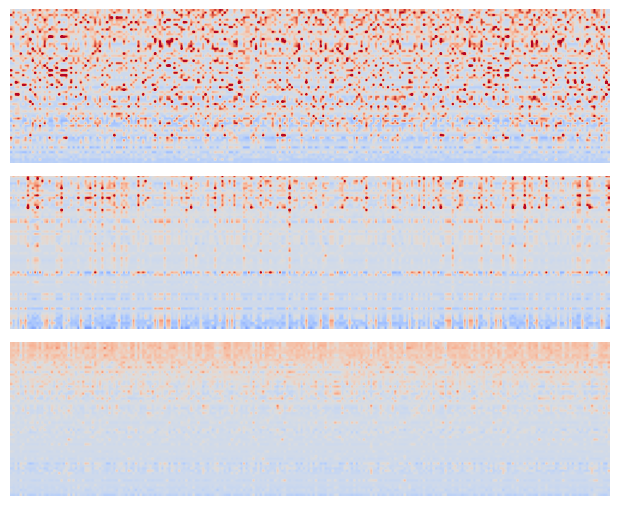

In [173]:
# 画一下 Redplot
from scipy.stats import zscore
whole_activ = np.r_[sampled_activs['gabor'], sampled_activs['color'], sampled_activs['shape']]
norm_activ = zscore(whole_activ)
# 创建图形和坐标轴
fig, ax = plt.subplots(3,1, figsize=(6,5))
# 调整子图参数
selected_trials = np.random.choice(np.arange(270), 250, replace=False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
draw_mat = norm_activ[0 : 270][selected_trials]
sort_idx = np.argsort(df["gabor-d'"])[::-1]
ax[0].imshow(draw_mat[:, sort_idx].T, cmap='coolwarm', aspect='equal', vmax=4, vmin=-4)

draw_mat = norm_activ[270 : 666][selected_trials]
sort_idx = np.argsort(df["color-d'"])[::-1]
ax[1].imshow(draw_mat[:, sort_idx].T, cmap='coolwarm', aspect='equal', vmax=4, vmin=-4)

draw_mat = norm_activ[666 ::][selected_trials]
sort_idx = np.argsort(df["shape-d'"])[::-1]
ax[2].imshow(draw_mat[:, sort_idx].T, cmap='coolwarm', aspect='equal', vmax=4, vmin=-4)

# plt.tight_layout()
for _ in ax:
    _.axis('off')
plt.show()

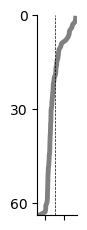

In [199]:
fig, ax = plt.subplots(figsize=(0.4,2))
# 调整子图参数
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(np.sort(df["shape-d'"]), np.arange(64), lw=3.5, color='gray')
ax.axvline(x=0, ls='--',lw=0.5, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0,64])
ax.set_yticks([64,34,4])
ax.set_yticklabels([0,30,60])
ax.set_xticks([-1,1])
ax.set_xticklabels([])
# ax.tick_params(axis='x', labelsize=7, rotation=270)  # 设置x轴刻度标签的字号
# ax.tick_params(axis='y', labelsize=5, rotation=270)  # 设置y轴刻度标签的字号
# ax.set_xticks([0,30,60])
# plt.tight_layout()
plt.axis()
plt.show()

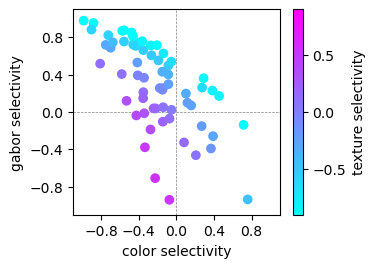

In [223]:
x = df['color-sls']
y = df['gabor-sls']
z = df['shape-sls']
plt.figure(figsize=(5/1.5,4/1.5))
plt.scatter(x,y,c=z,cmap='cool',vmax=.9,vmin=-.9,zorder=6)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.xticks([-.8,-.4,0,.4,.8])
plt.yticks([-.8,-.4,0,.4,.8])
plt.axhline(y=0,ls='--',color='gray',lw=0.5)
plt.axvline(x=0,ls='--',color='gray',lw=0.5)
plt.xlabel('color selectivity')
plt.ylabel('gabor selectivity')
# plt.axis('equal')
plt.colorbar(label='texture selectivity')

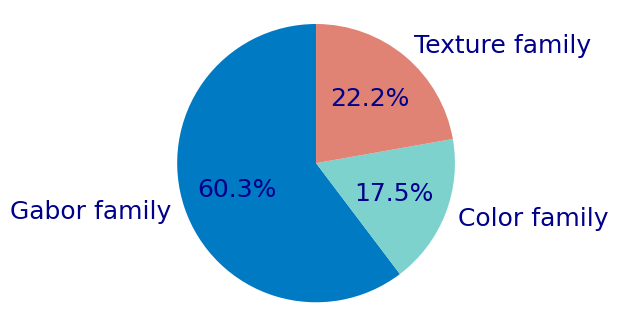

In [247]:

# 数据
sizes = [len(gabor_channel), len(color_channel), len(texture_channel)]
labels = ['Gabor family', 'Color family', 'Texture family']
colors = ["#007ac2","#7ed2cd","#e08274"]
text_color = 'darkblue'
#["#af9c6e","#b6ba99","#bad7c3"]

# 绘制饼图
fig, ax = plt.subplots(figsize=(4,4))
ax.pie(sizes,  labels=labels,autopct='%1.1f%%', startangle=90, colors=colors, textprops={'color': text_color,'size':18})

# 等比例显示，确保饼图是圆形
ax.axis('equal')

# 显示图表
plt.show()

In [244]:
np.where((df['gabor-sls'].values>0.6) &(df['color-sls'].values<0)&(df['shape-sls'].values<0))

(array([ 8, 11, 12, 13, 15, 16, 20, 24, 28, 31, 32, 36, 39, 40, 42, 44, 46,
        53, 59, 60, 62]),)

In [245]:
np.where((df['gabor-sls'].values<0) &(df['color-sls'].values>0.1)&(df['shape-sls'].values<0))

(array([ 9, 18, 23, 26, 58]),)

In [246]:
np.where((df['gabor-sls'].values<0) &(df['color-sls'].values<0)&(df['shape-sls'].values>0.1))

(array([ 2, 10, 27, 29, 34, 35, 55, 63]),)